## Set up Device

In [1]:
import torch

import os
import random
import matplotlib.pyplot as plt
import json
import re

import numpy as np
import pandas as pd

import helper

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
from PIL import Image

In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Make CSV file from JSON file

# Check if .csv files exists for dataset
if not os.path.exists("coins.csv"):
    print("File not found! Making file...")

    # Read from JSON file
    with open("archive/cat_to_name.json", "r") as f:
        # Load data
        data = json.load(f)

        # Create DataFrame
        # id - folder name
        # amount - currency amount
        # currency - name of currency
        # country - country that currency is from
        df = pd.DataFrame(data={
            "id": [key for key in data.keys()],
            "Amount": [value.split(",")[0] for value in data.values()],
            "Currency": [value.split(",")[1] for value in data.values()],
            "Country": [value.split(",")[2] for value in data.values()]
        })

        # Convert dataframe to .csv file
        csv_data = df.to_csv("coins.csv", index=False)

else:
    print("File already made!")

print(pd.read_csv("coins.csv"))

File already made!
      id      Amount           Currency    Country
0      1      1 Cent  Australian dollar  australia
1      2     2 Cents  Australian dollar  australia
2      3     5 Cents  Australian dollar  australia
3      4    10 Cents  Australian dollar  australia
4      5    20 Cents  Australian dollar  australia
..   ...         ...                ...        ...
206  207     5 Cents          US Dollar        usa
207  208      1 Dime          US Dollar        usa
208  209  1 4 Dollar          US Dollar        usa
209  210  1 2 Dollar          US Dollar        usa
210  211    1 Dollar          US Dollar        usa

[211 rows x 4 columns]


In [4]:
# Read CSV file 
df = pd.read_csv("coins.csv")

# Get all unique classes from amounts and currencies
amounts = df[:]["Amount"]
currencies = df[:]["Currency"]
countries = df[:]["Country"]
ids = df[:]["id"]

ids = list(ids)
classes = list(zip(amounts, countries))

In [5]:
rand_index = random.randint(0, len(classes))

classes[rand_index], ids[rand_index], rand_index

(('5 Korun', 'czech_republic'), 43, 42)

In [6]:
archive_path = Path("archive")

coin_path = archive_path / "coins"
data_path = coin_path / "data"

train_dir = data_path / "train"
valid_dir = data_path / "validation"

In [7]:
class CoinDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.transform = transform
        self.dataset_dir = dataset_dir
        self.images = list(self.dataset_dir.glob("*/*.jpg"))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # Get image path from list of images in dataset directory
        image_path = self.images[index]

        # Get name of image
        image_name = image_path.name

        # open image
        img = Image.open(image_path)

        # Get number of occurences that "_" is present
        occurence = [m.start() for m in re.finditer(r"_", image_name)]

        # Get amount associated with image
        amount = image_name.split("_")[2]

        # 4 occurences means that the country is two words, else its 1 word
        if len(occurence) == 4:
            # Split name at the middle point and omit ".jpg"
            country = image_name[occurence[len(occurence) // 2] + 1:image_name.index(".")]

        else:
            # Split name at the end
            country = image_name[occurence[len(occurence) - 1] + 1:image_name.index(".")]

        classes_index = classes.index((amount, country))
        
        '''
        if self.transform:
            return self.transform(img), ids[classes_index]
        
        return img, ids[classes_index]
        '''

        #print(image_name, classes[classes_index], ids[classes_index])
        return (self.transform(img), int(ids[classes_index])) if self.transform else (img, int(ids[classes_index]))

In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [9]:
train_data = CoinDataset(train_dir, transform)
valid_data = CoinDataset(valid_dir, transform)

len(train_data), len(valid_data)

(6413, 844)

In [10]:
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
imgs.shape

torch.Size([3, 64, 64, 6413])

In [11]:
mean = imgs.view(3, -1).mean(dim=1)
mean

tensor([0.5585, 0.5333, 0.4820])

In [12]:
std = imgs.view(3, -1).std(dim=1)
std

tensor([0.2529, 0.2534, 0.2777])

In [13]:
coin_stats = (mean, std)

In [26]:
normalize_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(*coin_stats)
])

In [27]:
train_data = CoinDataset(train_dir, normalize_transform)

In [28]:
def show_tensor_image(dataset, stats, classes):
    # Choose random image from dataset
    rand_index = random.randint(0, len(dataset))

    # Retrieve image and associated label
    img, label = dataset[rand_index][0], dataset[rand_index][1]

    # Denormalized image with calculations
    denorm_img = img * stats[1][0] + stats[0][0]

    # Display image as a tensor
    print(f"Image tensor:\n{img}")

    # Display shape of image
    print(f"Image shape: {img.shape}")

    print(f'Image Label: {classes[label - 1]}')
    # Display label associated with image: the actual label and its ID label
    print(f"Image ID Label: {label}")

    # Show the image filepath to verify label and image match up

    # Show denormalized image
    plt.imshow(denorm_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image tensor:
tensor([[[1.7459, 1.7459, 1.7459,  ..., 0.7999, 1.0015, 0.6914],
         [1.7459, 1.7459, 1.7459,  ..., 0.7844, 0.9395, 0.7534],
         [1.7459, 1.7459, 1.7459,  ..., 0.7534, 0.8465, 0.7069],
         ...,
         [1.7459, 1.7459, 1.7459,  ..., 0.7689, 0.8775, 0.6603],
         [1.7459, 1.7459, 1.7459,  ..., 0.7224, 0.8620, 0.6759],
         [1.7459, 1.7459, 1.7459,  ..., 0.5673, 0.6448, 0.6603]],

        [[1.8416, 1.8416, 1.8416,  ..., 0.9904, 1.1761, 0.9131],
         [1.8416, 1.8416, 1.8416,  ..., 0.9750, 1.0988, 0.9595],
         [1.8416, 1.8416, 1.8416,  ..., 0.9595, 1.0369, 0.9131],
         ...,
         [1.8416, 1.8416, 1.8416,  ..., 0.9595, 1.0523, 0.8666],
         [1.8416, 1.8416, 1.8416,  ..., 0.9285, 1.0369, 0.8821],
         [1.8416, 1.8416, 1.8416,  ..., 0.7738, 0.8512, 0.8821]],

        [[1.8654, 1.8654, 1.8654,  ..., 1.2299, 1.3570, 1.1593],
         [1.8654, 1.8654, 1.8654,  ..., 1.2158, 1.2864, 1.2017],
         [1.8654, 1.8654, 1.8654,  ..., 1.20

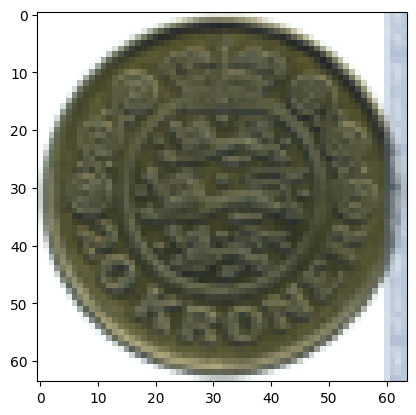

In [38]:
show_tensor_image(train_data, coin_stats, classes)

In [203]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

print(NUM_WORKERS)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

In [204]:
train_dataloader_iter = iter(train_dataloader)

for i in range(BATCH_SIZE):
    x, y = next(train_dataloader_iter)

    print(x, y)